In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm

%matplotlib inline

/var/folders/gv/4nk2tvfd4tjdhkr_hnd4tsz00000gn/T/ipykernel_86849/3975060195.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def dataframe_to_train_test_tensors(df, target, train_rate=0.9, shuffle=True):
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)

    x_df = df.drop(columns=[target])
    y_df = df[[target]]
    
    train_size = int(train_rate * len(df))
    
    x_train = torch.tensor(x_df.iloc[:train_size].values, dtype=torch.float64)
    y_train = torch.tensor(y_df.iloc[:train_size].values, dtype=torch.float64)
    x_test = torch.tensor(x_df.iloc[train_size:].values, dtype=torch.float64)
    y_test = torch.tensor(y_df.iloc[train_size:].values, dtype=torch.float64)

    return x_train, y_train, x_test, y_test

In [3]:
df = pd.read_csv('data/1ao_2rs_f.csv')

In [4]:
x_train, y_train, x_test, y_test = dataframe_to_train_test_tensors(df, 'is_identical', train_rate=0.9, shuffle=True)

In [5]:
class Simple2LayersOptimizer(nn.Module):
    def __init__(self, input_size, output_size):
        super(Simple2LayersOptimizer, self).__init__()
        
        self.fc1 = nn.Linear(input_size, input_size).double()
        self.fc2 = nn.Linear(input_size, output_size).double()

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        return out

    def print(self):
        print(self.fc1)

In [23]:
def train(model, optimizer, criterion, scheduler, x_train, y_train, n_epochs=20000, target_loss=0.25, enable_plots=True, message_rate=1):
    losses_train = []
    losses_test = []
    lrs = []
    progressbar = tqdm(range(n_epochs))
    for epoch in progressbar:
        if epoch % message_rate == (message_rate - 1):
            progressbar.set_description(f'Epoch {epoch+1}')
        
        optimizer.zero_grad()
        
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]['lr'])
        losses_train.append(loss.item())
        with torch.no_grad():
            losses_test.append(criterion(model(x_test), y_test).item())

        if epoch % message_rate == (message_rate - 1):
            progressbar.set_postfix({'loss': loss.item()})

        scheduler.step()

        if loss.item() < target_loss:
            break
    
    if enable_plots:
        fig, axis = plt.subplots(1, 2, figsize=(12, 6))
    
        axis[0].set_title("Loss");                  axis[1].set_title("Learning rate")
        axis[0].set_xlabel("N_epoch");              axis[1].set_xlabel("N_epoch")
        axis[0].set_ylabel("Loss");                 axis[1].set_ylabel("Learning rate")
        axis[0].semilogy();                         # axis[1].semilogy()
        axis[0].grid();                             axis[1].grid()
        axis[0].plot(losses_train, label='train');  axis[1].plot(lrs)
        axis[0].plot(losses_test, label='test');
        axis[0].legend();

  0%|          | 0/30000 [00:00<?, ?it/s]

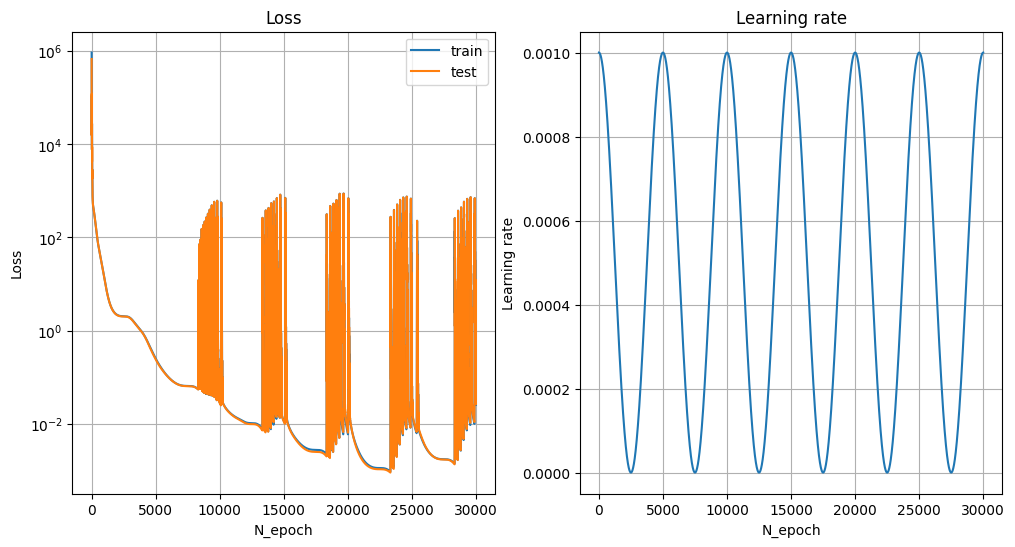

In [34]:
def lr_lambda(t):
    eta_max = 1e-6
    eta_min = 1e-6
    n_start = 0
    n_epochs = 100000
    
    if t <= 5000:
        eta_max = 1e-3
        eta_min = 1e-4
        n_start = 0
        n_epochs = 5000
    elif t <= 10000:
        eta_max = 1e-4
        eta_min = 1e-6
        n_start = 5000
        n_epochs = 5000
    
    return eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(np.pi * (t - n_start) / n_epochs))


def f(t):
    if 0 <= t < 5000:
        eta_min = 1e-4
        eta_max = 1e-3
        n_epochs = 5000
        n_start = 0
        return eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(np.pi * (t - n_start) / n_epochs))
    elif 5000 <= t < 12500:
        return 1e-4
    else:
        return 1e-5


def g(t):
    eta_min = 1e-6
    eta_max = 1e-3
    n_epochs = 2500
    return eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(np.pi * t / n_epochs))

n_epochs = 30000
model = Simple2LayersOptimizer(input_size=x_train.shape[1], output_size=y_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1.0)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=g)

train(model, optimizer, criterion, scheduler, x_train, y_train, n_epochs=n_epochs, target_loss=0.0001)

In [35]:
with torch.no_grad():
    print(f'Train loss : {criterion(model(x_train), y_train)}')
    print(f'Test loss  : {criterion(model(x_test), y_test)}')

Train loss : 0.059240466086364324
Test loss  : 0.0596823455844088


In [36]:
df_g = pd.read_csv('data/1ao_2rs_g.csv')
x_test_g, y_test_g = dataframe_to_train_test_tensors(df_g, 'is_identical', train_rate=0.0, shuffle=True)[2:]

In [37]:
with torch.no_grad():
    print(f'Test loss on new system : {criterion(model(x_test_g), y_test_g)}')

Test loss on new system : 9.407891478908216


In [38]:
df_h = pd.read_csv('data/1ao_2rs_h.csv')
x_test_h, y_test_h = dataframe_to_train_test_tensors(df_h, 'is_identical', train_rate=0.0, shuffle=True)[2:]

In [39]:
with torch.no_grad():
    print(f'Test loss on new system : {criterion(model(x_test_h), y_test_h)}')

Test loss on new system : 26.085763212445944
